In [1]:
# imports
import os
import sys
import pickle
import torch
import re
import spacy
import nltk
import en_core_web_sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.tag import StanfordNERTagger
from nltk.tokenize import word_tokenize
from torch import nn
from spacy import displacy
from collections import defaultdict
from collections import Counter

working_dir = '../src/models'
sys.path.append(os.path.abspath(working_dir))
from use_evaluation_model_transe import load_data, TransE
from api import EvaluationModel, NegSampleGenerator

In [2]:
# paths etc.
model_output_path = '../data/output/'
model_path = '../models/'
data_path = '/home/yuhao/workspace/Practical-Big-Data-Science/practical-big-data-science-adl-ai/data/processed/FB15k-237/'

In [3]:
# load data and dicts needed for model analysis

# train, valid and test triples
train_triples, valid_triples, test_triples = load_data(data_path)
all_true_triples = np.concatenate([train_triples, valid_triples,
                                   test_triples], axis=0)

# dictionaries to translate IDs into normal words (and vice versa)
path = os.path.join(data_path, 'id_to_relation.pickle')
id2relation = pickle.load(open(path, 'rb'))

path = os.path.join(data_path, 'relation_to_id.pickle')
relation2id = pickle.load(open(path, 'rb'))

path = os.path.join(data_path, 'id_to_entity.pickle')
id2entity = pickle.load(open(path, 'rb'))

path = os.path.join(data_path, 'entity_to_id.pickle')
entity2id = pickle.load(open(path, 'rb'))

path = os.path.join(data_path[:-10], 'mid2name.pkl')
mid2name = pickle.load(open(path, 'rb'))  # only strings!

name2mid = {name: mid for mid, name in mid2name.items()}

# count number of occurences of head entities, relations and tail entities in train
count_head_entities_train = defaultdict(int)
count_relations_train = defaultdict(int)
count_tail_entities_train = defaultdict(int)
for (s, p, o) in train_triples:
    count_head_entities_train[s] += 1
    count_relations_train[p] += 1
    count_tail_entities_train[o] += 1

# count number of occurences of head entities, relations and tail entities in test
count_head_entities_test = defaultdict(int)
count_relations_test = defaultdict(int)
count_tail_entities_test = defaultdict(int)
for (s, p, o) in test_triples:
    count_head_entities_test[s] += 1
    count_relations_test[p] += 1
    count_tail_entities_test[o] += 1

# count how often head-relation and relation-tail combinations occur
path = os.path.join(data_path, 'id_to_relation.pickle')
relations = set(pickle.load(open(path, 'rb')).keys())

head_rel_count = defaultdict(int)
rel_tail_count = defaultdict(int)
head_tail_count = defaultdict(int)
for triples in [train_triples, valid_triples, test_triples]:
    for (s, p, o) in triples:
        head_rel_count[s,p] += 1
        rel_tail_count[p,o] += 1
        head_tail_count[s,o] += 1
        
# categorize relationships into 0 = 1:1, 1 = 1:n, 2 = n:1, 3 = n:m
relation2type = dict()
for relation in relations:
    subject_counts = []
    object_counts = []
    considered_sp_tuples = set()
    considered_po_tuples = set()
    for triples in [train_triples, valid_triples, test_triples]:
        for (s, p, o) in triples:
            if relation == p:
                if (s, p) not in considered_sp_tuples:
                    considered_sp_tuples.add((s, p))
                    subject_counts.append(head_rel_count[(s, p)])
                if (p, p) not in considered_po_tuples:
                    considered_po_tuples.add((p, o))
                    object_counts.append(rel_tail_count[(p, o)])
                
    avg_subject_count = sum(subject_counts) / len(subject_counts)
    avg_object_count = sum(object_counts) / len(object_counts)

    if avg_subject_count < 1.5 and avg_object_count < 1.5:  # 
        relation2type[relation] = '1:1'  # 11 relations in the FB15k-237 dataset
    elif avg_subject_count < 1.5:
        relation2type[relation] = '1:n'  # 87 relations in the FB15k-237 dataset
    elif avg_object_count < 1.5:
        relation2type[relation] = 'n:1'  # 16 relations in the FB15k-237 dataset
    else:
        relation2type[relation] = 'n:m'  # 123 relations in the FB15k-237 dataset

assert sum(Counter(relation2type.values()).values()) == len(relations)

In [4]:
# create NERTagger
path1_classifier = '/home/yuhao/workspace/stanford-ner-2018-10-16/classifiers/english.all.3class.distsim.crf.ser.gz'
path2_classifier = '/home/yuhao/workspace/stanford-ner-2018-10-16/stanford-ner.jar'
st = StanfordNERTagger(path1_classifier, path2_classifier, encoding='utf-8')
nlp = en_core_web_sm.load()

# helper functions
all_triples = set(tuple(triple) for triple in all_true_triples)
error_id2description_head = {0: 'predicted head is actually correct',  # something went wrong!
                             1: 'predicted head is similar to true head, but not the same',
                             2: 'predicted head = given tail',
                             3: 'predicted head neither occured together with given relation nor with given tail',
                             4: 'predicted head and given relation never occured together',
                             5: 'predicted head and given tail never occured together',
                             6: 'wrong named entity type',
                             7: 'predicted head has correct named entity type and occured with the given relation'}

error_id2description_tail = {0: 'predicted tail is actually correct',  # something went wrong!
                             1: 'predicted tail is similar to true tail, but not the same',
                             2: 'predicted tail = given head',
                             3: 'predicted tail neither occured together with given relation nor with given head',
                             4: 'predicted tail and given relation never occured together',
                             5: 'predicted tail and given head never occured together',
                             6: 'wrong named entity type',
                             7: 'predicted tail has correct named entity type and occured with the given relation'}

def get_error_type(triple, predicted, mode):
    true_head_id = entity2id[name2mid[triple[0]]]
    true_relation_id = relation2id[triple[1]]
    true_tail_id = entity2id[name2mid[triple[2]]]
    error_type = set()

    if mode == 'head':
        predicted_head_id = entity2id[name2mid[predicted]]
        predicted_triple = tuple([predicted_head_id, true_relation_id, true_tail_id])
        if predicted_triple in all_triples:
            error_type.add(0)
        if triple[0] in predicted or predicted in triple[0]:
            error_type.add(1) 
    
        if predicted == triple[2]:
            error_type.add(2)
        current_head_rel_count = head_rel_count[(predicted_head_id, true_relation_id)]
        current_head_tail_count = head_tail_count[(predicted_head_id, true_tail_id)]
        if current_head_rel_count == 0 and current_head_tail_count == 0:
            error_type.add(3)
        if current_head_rel_count == 0:
            error_type.add(4)
        if current_head_tail_count == 0:
            error_type.add(5)
            
        ner_result1_correct_head = [ent.label_ for ent in nlp(triple[0]).ents]
        ner_result1_predicted_head = [ent.label_ for ent in nlp(predicted).ents]
        ner_result2_correct_head = st.tag(word_tokenize(triple[0]))
        ner_result2_correct_head = [tag for (word, tag) in ner_result2_correct_head]
        ner_result2_predicted_head = st.tag(word_tokenize(predicted))
        ner_result2_predicted_head = [tag for (word, tag) in ner_result2_predicted_head]
        
        if len(ner_result1_correct_head) > 0 and len(ner_result1_predicted_head) > 0:
            if ner_result1_correct_head != ner_result1_predicted_head \
            and ner_result2_correct_head != ner_result2_predicted_head:
                error_type.add(6)

        elif ner_result2_correct_head != ner_result2_predicted_head:
            error_type.add(6)
            
        elif ner_result1_correct_head == ner_result1_predicted_head \
        and ner_result2_correct_head == ner_result2_predicted_head \
        and current_head_rel_count > 0:  # and current_head_tail_count > 0
            error_type.add(7)  # predicted head could theoretically be true?

    elif mode == 'tail':
        predicted_tail_id = entity2id[name2mid[predicted]]

        predicted_triple = tuple([true_head_id, true_relation_id, predicted_tail_id])
        if predicted_triple in all_triples:
            error_type.add(0)
        
        if triple[2] in predicted or predicted in triple[2]:
            error_type.add(1) 
    
        if predicted == triple[0]:
            error_type.add(2)
        
        current_rel_tail_count = rel_tail_count[(true_relation_id, predicted_tail_id)]
        current_head_tail_count = head_tail_count[(true_head_id, predicted_tail_id)]
        if current_rel_tail_count == 0 and current_head_tail_count == 0:
            error_type.add(3)
        
        if current_rel_tail_count == 0:
            error_type.add(4)

        if current_head_tail_count == 0:
            error_type.add(5)

        ner_result1_correct_tail = [ent.label_ for ent in nlp(triple[2]).ents]
        ner_result1_predicted_tail = [ent.label_ for ent in nlp(predicted).ents]
        ner_result2_correct_tail = st.tag(word_tokenize(triple[2]))
        ner_result2_correct_tail = [tag for (word, tag) in ner_result2_correct_tail]
        ner_result2_predicted_tail = st.tag(word_tokenize(predicted))
        ner_result2_predicted_tail = [tag for (word, tag) in ner_result2_predicted_tail]
        
        if len(ner_result1_correct_tail) > 0 and len(ner_result1_predicted_tail) > 0:
            if ner_result1_correct_tail != ner_result1_predicted_tail \
            and ner_result2_correct_tail != ner_result2_predicted_tail:
                error_type.add(6)

        elif ner_result2_correct_tail != ner_result2_predicted_tail:
            error_type.add(6)
            
        elif ner_result1_correct_tail == ner_result1_predicted_tail \
        and ner_result2_correct_tail == ner_result2_predicted_tail \
        and current_rel_tail_count > 0:  # and current_head_tail_count > 0
            error_type.add(7)  # predicted tail could theoretically be true?

    else:
        raise ValueError('mode %s does not exit' % (mode))

    return error_type

In [5]:
# create EvaluationModel that can be used for single predictions
hidden_dim = 1000  # variabel parameter (depends on the model)

epsilon = 2.0
gamma = nn.Parameter(
    torch.Tensor([9.0]),
    requires_grad=False
)
embedding_range = nn.Parameter(
    torch.Tensor([(gamma.item() + epsilon) / hidden_dim]),
    requires_grad=False
)

# load already trained embeddings
neg_sample_generator = NegSampleGenerator(all_true_triples,
                                          create_filter_bias=True,
                                          bias=-1000)
model = EvaluationModel(model_class=TransE( gamma),
                        neg_sample_generator=neg_sample_generator)

path = os.path.join(model_path, 'entity_embedding.npy')
new_entity_embedding = nn.Parameter(torch.from_numpy(np.load(path)))
model.change_entity_embedding(new_entity_embedding.cuda())

path = os.path.join(model_path, 'relation_embedding.npy')
new_relation_embedding = nn.Parameter(torch.from_numpy(np.load(path)))
model.change_relation_embedding(new_relation_embedding.cuda())

model.cuda()
model.eval()

EvaluationModel()

In [6]:
# load prediction_table_head.pkl
path = os.path.join(model_output_path, 'prediction_table_head.pkl')
prediction_table_head = pd.read_pickle(path)
prediction_table_head['rank of true head'] = pd.to_numeric(prediction_table_head['rank of true head'],
                                                           downcast='integer')
s = []
p = []
o = []
topics = []
for _, triple_str in prediction_table_head['triple'].iteritems():
    triple = re.split(',', triple_str[1:-1])
    s.append(int(triple[0].strip()))
    p.append(int(triple[1].strip()))
    o.append(int(triple[2].strip()))
    topics.append(id2relation[int(triple[1].strip())].split('/')[1])

prediction_table_h = pd.DataFrame(columns=['s', 'p', 'o', 'rank'])
prediction_table_h['s'] = s
prediction_table_h['p'] = p
prediction_table_h['o'] = o
prediction_table_h['rank'] = prediction_table_head['rank of true head']
prediction_table_h['topic'] = topics

easy relations for head prediction (10 relations with the lowest average rank):

/language/human_language/countries_spoken_in
/film/film_distributor/films_distributed./film/film_film_distributor_relationship/film
/music/genre/artists
/celebrities/celebrity/sexual_relationships./celebrities/romantic_relationship/celebrity
/education/educational_degree/people_with_this_degree./education/education/student
/tv/tv_network/programs./tv/tv_network_duration/program
/organization/organization/headquarters./location/mailing_address/state_province_region
/base/schemastaging/person_extra/net_worth./measurement_unit/dated_money_value/currency
/film/film/runtime./film/film_cut/film_release_region
/people/person/spouse_s./people/marriage/location_of_ceremony



difficult relations for head prediction (10 relations with the highest average rank):

/people/cause_of_death/people
/base/marchmadness/ncaa_basketball_tournament/seeds./base/marchmadness/ncaa_tournament_seed/team
/business/business_operation/

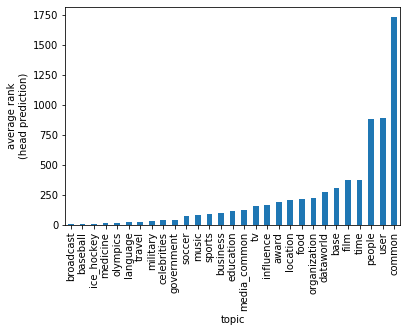

examples for "easy" topics:

example for topic broadcast: /broadcast/content/artist
example for topic baseball: /baseball/baseball_team/team_stats./baseball/baseball_team_stats/season
example for topic ice_hockey: /ice_hockey/hockey_team/current_roster./sports/sports_team_roster/position
example for topic medicine: /medicine/symptom/symptom_of
example for topic olympics: /olympics/olympic_sport/athletes./olympics/olympic_athlete_affiliation/country


examples for "difficult" topics:

example for topic film: /film/film_subject/films
example for topic time: /time/event/instance_of_recurring_event
example for topic people: /people/person/gender
example for topic user: /user/tsegaran/random/taxonomy_subject/entry./user/tsegaran/random/taxonomy_entry/taxonomy
example for topic common: /common/topic/webpage./common/webpage/category


In [7]:
# analyse prediction_table_head.pkl
# find "easy" relations (relations that are part of triples with a good rank) and "difficult" relations
print('easy relations for head prediction (10 relations with the lowest average rank):\n')
for row in prediction_table_h[['p', 'rank']].groupby('p', as_index=False)['rank'].mean().\
                                             sort_values(by='rank').head(10).iterrows():
    print(id2relation[row[0]])

print('\n\n\ndifficult relations for head prediction (10 relations with the highest average rank):\n')
for row in prediction_table_h[['p', 'rank']].groupby('p', as_index=False)['rank'].mean().\
                                             sort_values(by='rank', ascending=False).head(10).iterrows():
    print(id2relation[row[0]])
    
print('\n\n\naverage rank of each topic (head prediction):')

df = prediction_table_h[['topic', 'rank']].groupby('topic', as_index=False)['rank'].mean().\
                                           sort_values(by='rank')
ax = df.plot.bar(x='topic', y='rank', rot=90, legend=False).set_ylabel('average rank\n(head prediction)')
plt.show()

# find examples for the "easy" topics
print('examples for "easy" topics:\n')
for index, topic in df.head(5)['topic'].iteritems():
    for index, row in prediction_table_h[['p', 'rank', 'topic']].sort_values(by='rank')[['p', 'topic']].iterrows():
        if row['topic'] == topic:
            print('example for topic {}: {}'.format(topic, id2relation[row['p']]))
            break

print('\n\nexamples for "difficult" topics:\n')
# find examples for the "difficult" topics
for index, topic in df.tail(5)['topic'].iteritems():
    for index, row in prediction_table_h[['p', 'rank', 'topic']].sort_values(by='rank', ascending=False)[['p', 'topic']].iterrows():
        if row['topic'] == topic:
            print('example for topic {}: {}'.format(topic, id2relation[row['p']]))
            break

proportion of relation types: {'n:m': 0.261, 'n:1': 0.157, '1:n': 0.545, '1:1': 0.037}


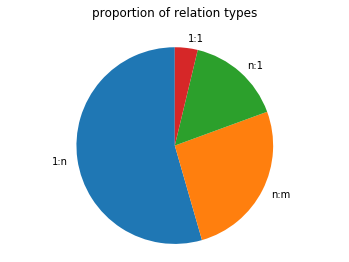

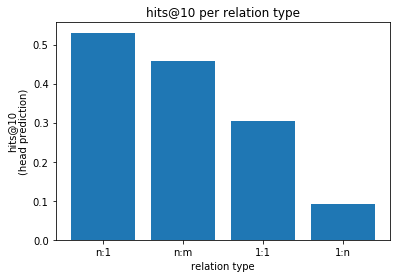

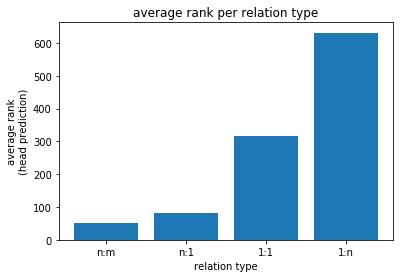

Hint: higher is better for hits@10, lower is better for the average rank



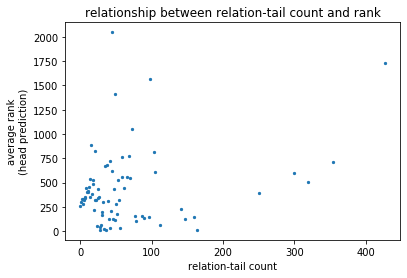

In [8]:
# analyse prediction_table_head.pkl
# plot relationship between relation-tail count and rank
rel_tail_count_to_avg_rank = dict()
relation_type_to_avg_rank = dict()  # keys: 1:1, 1:n, n:1, n:m
relation_type_to_hits10 = defaultdict(int)
relation_type_count = defaultdict(int)

for index, row in prediction_table_h.iterrows():
    relation_type = relation2type[row['p']]
    if row['rank'] <= 10:
        relation_type_to_hits10[relation_type] += 1
    relation_type_count[relation_type] += 1
        
    if relation_type not in relation_type_to_avg_rank:
        relation_type_to_avg_rank[relation_type] = (row['rank'], 1)
    else:
        relation_type_to_avg_rank[relation_type] = (relation_type_to_avg_rank[relation_type][0] +
                                                   row['rank'],
                                                   relation_type_to_avg_rank[relation_type][1] + 1)

    count_left = head_rel_count[(row['s'], row['p'])]
    count_right = rel_tail_count[(row['p'], row['o'])]
    if count_right not in rel_tail_count_to_avg_rank:
        rel_tail_count_to_avg_rank[count_right] = (row['rank'], 1)
    else:
        rel_tail_count_to_avg_rank[count_right] = (rel_tail_count_to_avg_rank[count_right][0] +
                                                   row['rank'],
                                                   rel_tail_count_to_avg_rank[count_right][1] + 1)

values_sum = sum(relation_type_count.values())
relation_type_to_proportion = {relation_type: round(count / values_sum, 3)
                               for relation_type, count in relation_type_count.items()}
print('proportion of relation types: ' + str(relation_type_to_proportion))

labels = sorted(relation_type_count, key=relation_type_count.get, reverse=True)
sizes = [relation_type_count[label] for label in labels]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, shadow=False, startangle=90)
ax1.axis('equal')
plt.title('proportion of relation types\n')
plt.show()

for relation_type in relation_type_to_hits10:
    relation_type_to_hits10[relation_type] = relation_type_to_hits10[relation_type] \
                                             / relation_type_count[relation_type]

x = []
y = []
for relation_type in sorted(relation_type_to_hits10, key=relation_type_to_hits10.get, reverse=True):
    x.append(relation_type)
    y.append(relation_type_to_hits10[relation_type])
plt.bar(range(len(x)), y)
plt.xticks(range(len(x)), x)
plt.title('hits@10 per relation type')
plt.xlabel('relation type')
plt.ylabel('hits@10\n(head prediction)')
plt.show()
print()

for relation_type, (sum_rank, num) in relation_type_to_avg_rank.items():
    relation_type_to_avg_rank[relation_type] = sum_rank / num

x = []
y = []
for relation_type in sorted(relation_type_to_avg_rank, key=relation_type_to_avg_rank.get):
    x.append(relation_type)
    y.append(relation_type_to_avg_rank[relation_type])
plt.bar(range(len(x)), y)
plt.xticks(range(len(x)), x)
plt.title('average rank per relation type')
plt.xlabel('relation type')
plt.ylabel('average rank\n(head prediction)')
plt.show()

print('Hint: higher is better for hits@10, lower is better for the average rank\n')

for count, (sum_rank, num) in rel_tail_count_to_avg_rank.items():
    rel_tail_count_to_avg_rank[count] = sum_rank / num

x = []
y = []
for count in sorted(rel_tail_count_to_avg_rank):
    x.append(count)
    y.append(rel_tail_count_to_avg_rank[count])
    
plt.figure()
plt.title('relationship between relation-tail count and rank')
plt.xlabel('relation-tail count')
plt.ylabel('average rank\n(head prediction)')
plt.scatter(x, y, s=5)
plt.show()

In [9]:
# analyse prediction_table_head.pkl
# when is the models ranking bad? is there specific a pattern?
mask = prediction_table_h['rank'] > int(14541/2)  # 14541 = num diff. entities
prediction_table_bad = prediction_table_h[mask]
print('There are {} very bad head predictions:'.format(prediction_table_bad.shape[0]))
print('Hint: the numbers stand for a property of the corresponding triple (see more below)\n')

error_id_count = defaultdict(int)
triples_count = 0
rel_tail_counts_bad = set()
for index, row in prediction_table_bad.iterrows():
    rel_tail_counts_bad.add(rel_tail_count[(row[1], row[2])])
    head = id2entity[row[0]]
    relation = id2relation[row[1]]
    tail = id2entity[row[2]]

    head_id = torch.tensor([row[0]]).cuda()
    relation_id = torch.tensor([row[1]]).cuda()
    tail_id = torch.tensor([row[2]]).cuda()
    scores_subject = model.predict_subject_scores(head_id, relation_id, tail_id)
    argsort_subject = torch.argsort(scores_subject, dim=1, descending=True)
    models_top10 = []
    for entity_id in argsort_subject[0][:10]:
        try:
            entity_name = mid2name[id2entity[entity_id.item()]]
            models_top10.append(entity_name)
        except:  # entity unknown
            pass
            
    # rank_subject = (argsort_subject == head_id).nonzero()
    # rank_subject = 1 + rank_subject[0][1].item()
    # assert rank_subject == row[3]

    try:
        mid2name[tail]
        print('\ncorrect head: ' + mid2name[head])
        print('given relation: ' + relation)
        print('given tail: ' + mid2name[tail])
        print('instead of the correct entity these entities got a high score:\n')
        error_type_table = pd.DataFrame(columns=['entity name']+[i for i in range(8)])
        for entity_name in models_top10:
            try: 
                triple = (mid2name[head], relation, mid2name[tail])
                error_type = get_error_type(triple, predicted=entity_name, mode='head')
                row_dict = {'entity name': entity_name}
                row_dict.update({error_id: 'x' for error_id in error_type})
                error_type_table = error_type_table.append(row_dict, ignore_index=True)
                for error_id in error_type:
                    error_id_count[error_id] += 1
                triples_count += 1
            except Exception as e:
                print(e)
        print(error_type_table.fillna('').to_string(index=False))
        print()
    except:  # entity unknown
        pass

print('\n\ndescription for every error_id: ' + str(error_id2description_head))

error_id2percentage = {error_id: round(error_id_count[error_id] / triples_count, 3)
                       for error_id in error_id_count}
error_id2percentage = sorted(error_id2percentage.items())
print('\npercentage of very bad head predictions with the corresponding error_id: ' + str(error_id2percentage))

avg_rel_tail_count_bad = sum(rel_tail_counts_bad) / len(rel_tail_counts_bad)
print('\naverage relation-tail count for these very bad head predictions: ' + str(avg_rel_tail_count_bad))

There are 31 very bad head predictions:
Hint: the numbers stand for a property of the corresponding triple (see more below)


correct head: Charlie Parker
given relation: /film/film_subject/films
given tail: Bird
instead of the correct entity these entities got a high score:

    entity name 0 1 2 3 4  5  6 7
        tragedy            x  x  
         racism            x  x  
 Sicilian Mafia            x     
  serial killer            x  x  
      Christmas            x  x  
      terrorism            x  x  
     pedophilia            x  x  
         prison            x  x  
       feminism            x  x  
       aviation            x  x  


correct head: Joan Crawford
given relation: /film/film_subject/films
given tail: Mommie Dearest
instead of the correct entity these entities got a high score:

    entity name 0 1 2 3 4  5  6 7
         racism            x  x  
        tragedy            x  x  
       feminism            x  x  
 Sicilian Mafia            x     
       aviation  

In [10]:
# analyse prediction_table_head.pkl
# when is the models ranking good? is there specific a pattern?
mask = prediction_table_h['rank'] == 1
prediction_table_perfect_h = prediction_table_h[mask]
print('There are {} perfect head predictions:\n'.format(prediction_table_perfect_h.shape[0]))

rel_tail_counts_good = set()
for index, row in prediction_table_perfect_h.iterrows():
    rel_tail_counts_good.add(rel_tail_count[(row[1], row[2])])
    head = id2entity[row[0]]
    relation = id2relation[row[1]]
    tail = id2entity[row[2]]
    try:
        mid2name[tail]
        print(mid2name[head])
        print(relation)
        print(mid2name[tail])
        print()
    except:  # entity unknown
        pass

avg_rel_tail_count_good = sum(rel_tail_counts_good) / len(rel_tail_counts_good)
print('average relation-tail count for these good head predictions: ' + str(avg_rel_tail_count_good))

There are 1718 perfect head predictions:

England
/location/location/contains
Pontefract

prime minister
/government/government_office_category/officeholders./government/government_position_held/jurisdiction_of_office
Liechtenstein

2008 Summer Olympics
/olympics/olympic_games/participating_countries
Djibouti

2008 Summer Olympics
/olympics/olympic_games/participating_countries
Mauritania

Grammy Award for Best Country Album
/award/award_category/winners./award/award_honor/ceremony
2001 Grammy Awards

Los Angeles Rams
/sports/sports_team/sport
American football

African Americans
/people/ethnicity/people
John Lee Hooker

Decca
/music/record_label/artist
Nat King Cole

Academy Award for Best Sound Mixing
/award/award_category/nominees./award/award_nomination/nominated_for
Fame

egg
/food/food/nutrients./food/nutrition_fact/nutrient
pantothenic acid

Broadcast Film Critics Association Award for Best Film
/award/award_category/nominees./award/award_nomination/nominated_for
The Pianist

Co

19th United States Congress
/government/legislative_session/members./government/government_position_held/district_represented
Ohio

19th United States Congress
/government/legislative_session/members./government/government_position_held/district_represented
New Jersey

St. Louis Cardinals
/sports/professional_sports_team/draft_picks./sports/sports_league_draft_pick/school
Arizona State University

X-Men: The Last Stand
/film/film/estimated_budget./measurement_unit/dated_money_value/currency
United States dollar

United Kingdom
/location/location/contains
Westminster

Juris Doctor
/education/educational_degree/people_with_this_degree./education/education/student
Joe Biden

Hackensack
/location/hud_county_place/place
Hackensack

Writers Guild of America Awards 2006
/award/award_ceremony/awards_presented./award/award_honor/award_winner
Michael Schur

60th Primetime Emmy Awards
/award/award_ceremony/awards_presented./award/award_honor/award_winner
Robert Carlock

Albert Einstein
/people/pe

Juris Doctor
/education/educational_degree/people_with_this_degree./education/education/institution
Michigan State University

The Tourist
/film/film/release_date_s./film/film_regional_release_date/film_release_region
Brazil

Hattiesburg
/location/hud_county_place/place
Hattiesburg

BAFTA Award for Best Editing
/award/award_category/nominees./award/award_nomination/nominated_for
All the President's Men

pop music
/music/genre/artists
Lena Horne

councillor
/government/government_office_category/officeholders./government/government_position_held/jurisdiction_of_office
Berkeley

councillor
/government/government_office_category/officeholders./government/government_position_held/jurisdiction_of_office
Burbank

attention deficit hyperactivity disorder
/medicine/disease/notable_people_with_this_condition
Liv Tyler

Irish Americans
/people/ethnicity/people
Ellen Burstyn

track cycling
/olympics/olympic_sport/athletes./olympics/olympic_athlete_affiliation/country
Spain

United States of Ameri

rhythm and blues
/music/genre/artists
Selena Gomez

Barnard College
/organization/non_profit_organization/registered_with./organization/non_profit_registration/registering_agency
Internal Revenue Service

prime minister
/government/government_office_category/officeholders./government/government_position_held/jurisdiction_of_office
Burundi

African Americans
/people/ethnicity/people
Michael Jackson

African Americans
/people/ethnicity/people
Billy Preston

Rich Little
/base/americancomedy/celebrity_impressionist/celebrities_impersonated
Dwight D. Eisenhower

Cleveland Indians
/sports/professional_sports_team/draft_picks./sports/sports_league_draft_pick/draft
1997 Major League Baseball draft

Robert Gates
/people/person/employment_history./business/employment_tenure/company
Harvard University

mayor
/government/government_office_category/officeholders./government/government_position_held/jurisdiction_of_office
Orlando

Bachelor of Science
/education/educational_degree/people_with_this_de

In [11]:
# load prediction_table_tail.pkl
path = os.path.join(model_output_path, 'prediction_table_tail.pkl')
prediction_table_tail = pd.read_pickle(path)
prediction_table_tail['rank of true tail'] = pd.to_numeric(prediction_table_tail['rank of true tail'],
                                                           downcast='integer')

s = []
p = []
o = []
topics = []
for _, triple_str in prediction_table_tail['triple'].iteritems():
    triple = re.split(',', triple_str[1:-1])
    s.append(int(triple[0].strip()))
    p.append(int(triple[1].strip()))
    o.append(int(triple[2].strip()))
    topics.append(id2relation[int(triple[1].strip())].split('/')[1])

prediction_table_t = pd.DataFrame(columns=['s', 'p', 'o', 'rank'])
prediction_table_t['s'] = s
prediction_table_t['p'] = p
prediction_table_t['o'] = o
prediction_table_t['rank'] = prediction_table_tail['rank of true tail']
prediction_table_t['topic'] = topics

easy relations for tail prediction (10 relations with the lowest average rank):

/american_football/football_team/current_roster./sports/sports_team_roster/position
/celebrities/celebrity/sexual_relationships./celebrities/romantic_relationship/celebrity
/education/educational_degree/people_with_this_degree./education/education/student
/education/educational_institution/students_graduates./education/education/student
/film/actor/film./film/performance/film
/film/film/distributors./film/film_film_distributor_relationship/film_distribution_medium
/film/film/release_date_s./film/film_regional_release_date/film_release_region
/film/film_distributor/films_distributed./film/film_film_distributor_relationship/film
/language/human_language/countries_spoken_in
/location/administrative_division/country



difficult relations for tail prediction (10 relations with the highest average rank):

/sports/sports_team_location/teams
/base/biblioness/bibs_location/country
/education/educational_degree/peo

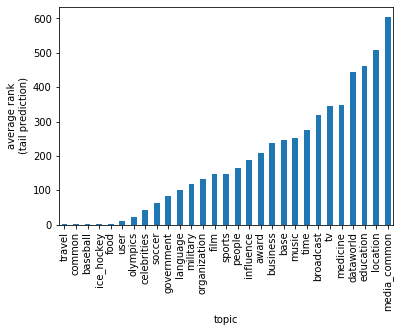

examples for "easy" topics:

example for topic travel: /travel/travel_destination/climate./travel/travel_destination_monthly_climate/month
example for topic common: /common/topic/webpage./common/webpage/category
example for topic baseball: /baseball/baseball_team/team_stats./baseball/baseball_team_stats/season
example for topic ice_hockey: /ice_hockey/hockey_team/current_roster./sports/sports_team_roster/position
example for topic food: /food/food/nutrients./food/nutrition_fact/nutrient


examples for "difficult" topics:

example for topic medicine: /medicine/disease/notable_people_with_this_condition
example for topic dataworld: /dataworld/gardening_hint/split_to
example for topic education: /education/educational_institution/students_graduates./education/education/student
example for topic location: /location/location/contains
example for topic media_common: /media_common/netflix_genre/titles


In [12]:
# analyse prediction_table_tail.pkl
# find "easy" relations (relations that are part of triples with a good rank) and "difficult" relations

print('easy relations for tail prediction (10 relations with the lowest average rank):\n')
for row in prediction_table_t[['p', 'rank']].groupby('p', as_index=False)['rank'].mean().\
                                             sort_values(by='rank').head(10).iterrows():
    print(id2relation[row[0]])

print('\n\n\ndifficult relations for tail prediction (10 relations with the highest average rank):\n')
for row in prediction_table_t[['p', 'rank']].groupby('p', as_index=False)['rank'].mean().\
                                             sort_values(by='rank', ascending=False).head(10).iterrows():
    print(id2relation[row[0]])
    
print('\n\n\naverage rank of each topic (tail prediction:')
df = prediction_table_t[['topic', 'rank']].groupby('topic', as_index=False)['rank'].mean().\
                                           sort_values(by='rank')
ax = df.plot.bar(x='topic', y='rank', rot=90, legend=False).set_ylabel('average rank\n(tail prediction)')
plt.show()

# find examples for the "easy" topics
print('examples for "easy" topics:\n')
for index, topic in df.head(5)['topic'].iteritems():
    for index, row in prediction_table_t[['p', 'rank', 'topic']].sort_values(by='rank')[['p', 'topic']].iterrows():
        if row['topic'] == topic:
            print('example for topic {}: {}'.format(topic, id2relation[row['p']]))
            break

# find examples for the "difficult" topics
print('\n\nexamples for "difficult" topics:\n')
for index, topic in df.tail(5)['topic'].iteritems():
    for index, row in prediction_table_t[['p', 'rank', 'topic']].sort_values(by='rank', ascending=False)[['p', 'topic']].iterrows():
        if row['topic'] == topic:
            print('example for topic {}: {}'.format(topic, id2relation[row['p']]))
            break

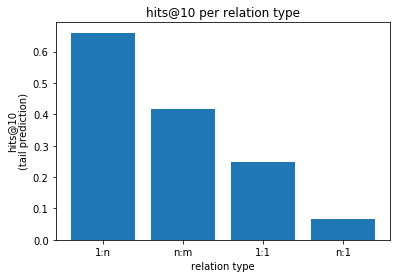

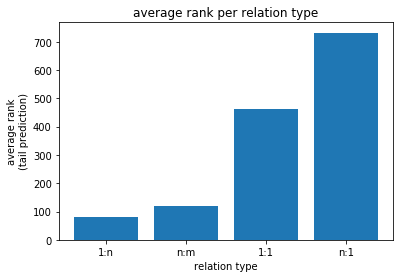

Hint: higher is better for hits@10, lower is better for the average rank



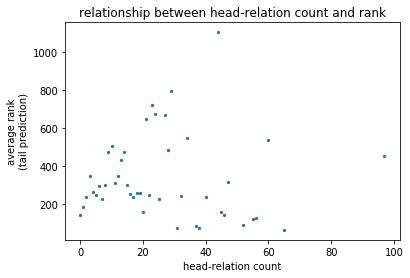

In [13]:
# analyse prediction_table_tail.pkl
# plot relationship between head-relation count and rank
head_rel_count_to_avg_rank = dict()
relation_type_to_avg_rank = dict()
relation_type_to_hits10 = defaultdict(int)
relation_type_count = defaultdict(int)

for index, row in prediction_table_t.iterrows():
    relation_type = relation2type[row['p']]
    if row['rank'] <= 10:
        relation_type_to_hits10[relation_type] += 1
    relation_type_count[relation_type] += 1

    if relation_type not in relation_type_to_avg_rank:
        relation_type_to_avg_rank[relation_type] = (row['rank'], 1)
    else:
        relation_type_to_avg_rank[relation_type] = (relation_type_to_avg_rank[relation_type][0] +
                                                    row['rank'],
                                                    relation_type_to_avg_rank[relation_type][1] + 1)

    count_left = head_rel_count[(row['s'], row['p'])]
    count_right = rel_tail_count[(row['p'], row['o'])]
    if count_left not in head_rel_count_to_avg_rank:
        head_rel_count_to_avg_rank[count_left] = (row['rank'], 1)
    else:
        head_rel_count_to_avg_rank[count_left] = (head_rel_count_to_avg_rank[count_left][0] +
                                                  row['rank'],
                                                  head_rel_count_to_avg_rank[count_left][1] + 1)

for relation_type in relation_type_to_hits10:
    relation_type_to_hits10[relation_type] = relation_type_to_hits10[relation_type] \
                                             / relation_type_count[relation_type]

x = []
y = []
for relation_type in sorted(relation_type_to_hits10, key=relation_type_to_hits10.get, reverse=True):
    x.append(relation_type)
    y.append(relation_type_to_hits10[relation_type])
plt.bar(range(len(x)), y)
plt.xticks(range(len(x)), x)
plt.title('hits@10 per relation type')
plt.xlabel('relation type')
plt.ylabel('hits@10\n(tail prediction)')
plt.show()
print()

for relation_type, (sum_rank, num) in relation_type_to_avg_rank.items():
    relation_type_to_avg_rank[relation_type] = sum_rank / num

x = []
y = []
for relation_type in sorted(relation_type_to_avg_rank, key=relation_type_to_avg_rank.get):
    x.append(relation_type)
    y.append(relation_type_to_avg_rank[relation_type])
plt.bar(range(len(x)), y)
plt.xticks(range(len(x)), x)
plt.title('average rank per relation type')
plt.xlabel('relation type')
plt.ylabel('average rank\n(tail prediction)')
plt.show()

print('Hint: higher is better for hits@10, lower is better for the average rank\n')

for count, (sum_avg_rank, num) in head_rel_count_to_avg_rank.items():
    head_rel_count_to_avg_rank[count] = sum_avg_rank / num

x = []
y = []
for count in sorted(head_rel_count_to_avg_rank):
    x.append(count)
    y.append(head_rel_count_to_avg_rank[count])
    
plt.figure()
plt.title('relationship between head-relation count and rank')
plt.xlabel('head-relation count')
plt.ylabel('average rank\n(tail prediction)')
plt.scatter(x, y, s=5)
plt.show()

In [14]:
# analyse prediction_table_tail.pkl
# when is the models ranking bad? is there specific a pattern?
mask = prediction_table_t['rank'] > int(14541/2)  # 14541 = num diff. entities
prediction_table_bad = prediction_table_t[mask]
print('There are {} very bad tail predictions:'.format(prediction_table_bad.shape[0]))
print('Hint: the numbers stand for a property of the corresponding triple (see more below)\n')

error_id_count = defaultdict(int)
triples_count = 0
head_rel_counts_bad = set()
for index, row in prediction_table_bad.iterrows():
    head_rel_counts_bad.add(head_rel_count[(row[0], row[1])])
    head = id2entity[row[0]]
    relation = id2relation[row[1]]
    tail = id2entity[row[2]]

    head_id = torch.tensor([row[0]]).cuda()
    relation_id = torch.tensor([row[1]]).cuda()
    tail_id = torch.tensor([row[2]]).cuda()
    scores_object = model.predict_object_scores(head_id, relation_id, tail_id)
    argsort_object = torch.argsort(scores_object, dim=1, descending=True)
    models_top10 = []
    for entity_id in argsort_object[0][:10]:
        try:
            entity_name = mid2name[id2entity[entity_id.item()]]
            models_top10.append(entity_name)
        except:  # entity unknown
            pass
        
    # rank_object = (argsort_object == tail_id).nonzero()
    # rank_object = 1 + rank_object[0][1].item()
    # assert rank_object == row[3]

    try:
        mid2name[tail]
        print('\ngiven head: ' + mid2name[head])
        print('given relation: ' + relation)
        print('correct tail: ' + mid2name[tail])
        print('instead of the correct entity these entities got a high score: ')
        error_type_table = pd.DataFrame(columns=['entity name']+[i for i in range(8)])
        for entity_name in models_top10:
            try: 
                triple = (mid2name[head], relation, mid2name[tail])
                error_type = get_error_type(triple, predicted=entity_name, mode='tail')
                row_dict = {'entity name': entity_name}
                row_dict.update({error_id: 'x' for error_id in error_type})
                error_type_table = error_type_table.append(row_dict, ignore_index=True)
                for error_id in error_type:
                    error_id_count[error_id] += 1
                triples_count += 1
            except Exception as e:
                print(e)
        print(error_type_table.fillna('').to_string(index=False))
        print()
    except:  # entity unknown
        pass

print('\n\ndescription for every error_id: ' + str(error_id2description_tail))
error_id2percentage = {error_id: round(error_id_count[error_id] / triples_count, 3)
                       for error_id in error_id_count}
error_id2percentage = sorted(error_id2percentage.items())
print('\npercentage of very bad tail predictions with the corresponding error_id: ' + str(error_id2percentage))

avg_head_rel_count_bad = sum(head_rel_counts_bad) / len(head_rel_counts_bad)
print('\naverage head-relation count for these very bad tail predictions: ' + str(avg_head_rel_count_bad))

There are 8 very bad tail predictions:
Hint: the numbers stand for a property of the corresponding triple (see more below)


given head: 61st Primetime Emmy Awards
given relation: /award/award_ceremony/awards_presented./award/award_honor/honored_for
correct tail: 81st Academy Awards
instead of the correct entity these entities got a high score: 
            entity name 0 1 2  3  4  5  6 7
           Will & Grace              x     
                30 Rock              x  x  
                 Cheers        x  x  x  x  
                Frasier        x  x  x  x  
 The Larry Sanders Show        x  x  x  x  
                  Weeds              x  x  
           Murphy Brown        x  x  x  x  
            Ally McBeal        x  x  x  x  
          The Good Wife        x  x  x     
           The Practice        x  x  x  x  


given head: contemporary folk music
given relation: /music/genre/artists
correct tail: contemporary folk music
instead of the correct entity these entities got a high

In [15]:
# analyse prediction_table_tail.pkl
# when is the models ranking good? is there specific a pattern?
mask = prediction_table_t['rank'] == 1
prediction_table_perfect_t = prediction_table_t[mask]
print('There are {} perfect tail predictions:\n'.format(prediction_table_perfect_t.shape[0]))

head_rel_counts_good = set()
for index, row in prediction_table_perfect_t.iterrows():
    head_rel_counts_good.add(head_rel_count[(row[0], row[1])])
    head = id2entity[row[0]]
    relation = id2relation[row[1]]
    tail = id2entity[row[2]]
    try:
        mid2name[tail]
        print(mid2name[head])
        print(relation)
        print(mid2name[tail])
        print()
    except:  # entity unknown
        pass

avg_head_rel_count_good = sum(head_rel_counts_good) / len(head_rel_counts_good)
print('average head-relation count for these good tail predictions: ' + str(avg_head_rel_count_good))

There are 4675 perfect tail predictions:

Zürich
/travel/travel_destination/climate./travel/travel_destination_monthly_climate/month
October

Lycoming County
/location/statistical_region/rent50_2./measurement_unit/dated_money_value/currency
United States dollar

Grammy Award for Best Country Album
/award/award_category/winners./award/award_honor/ceremony
2000 Grammy Awards

Christianity
/user/tsegaran/random/taxonomy_subject/entry./user/tsegaran/random/taxonomy_entry/taxonomy
Library of Congress Classification

Tom Werner
/tv/tv_producer/programs_produced./tv/tv_producer_term/producer_type
executive producer

Los Angeles Rams
/sports/sports_team/sport
American football

Lincoln
/film/film/estimated_budget./measurement_unit/dated_money_value/currency
United States dollar

Bret Michaels
/people/person/profession
musician

Belgium
/organization/organization_member/member_of./organization/organization_membership/organization
League of Nations

Gangs of New York
/film/film/film_festivals
60

/education/educational_institution/colors
white

Final Destination 5
/film/film/genre
horror literature

Graeme Revell
/people/person/gender
male organism

Jenna Ushkowitz
/people/person/gender
female organism

21 Grams
/film/film/other_crew./film/film_crew_gig/film_crew_role
production sound mixer

Austin Powers: International Man of Mystery
/film/film/release_date_s./film/film_regional_release_date/film_release_distribution_medium
DVD

Carroll O'Connor
/people/person/spouse_s./people/marriage/type_of_union
marriage

Parkersburg
/location/location/time_zones
Eastern Time Zone

The World's Fastest Indian
/film/film/other_crew./film/film_crew_gig/film_crew_role
production sound mixer

Dubuque
/location/hud_foreclosure_area/estimated_number_of_mortgages./measurement_unit/dated_integer/source
United States Department of Housing and Urban Development

Big Daddy
/film/film/estimated_budget./measurement_unit/dated_money_value/currency
United States dollar

Santosh Sivan
/award/award_nominee/

Jayne Mansfield
/people/person/gender
female organism

Shanghai
/film/film/release_date_s./film/film_regional_release_date/film_release_region
Hungary

House of Flying Daggers
/film/film/release_date_s./film/film_regional_release_date/film_release_region
Belgium

Transamerica
/film/film/estimated_budget./measurement_unit/dated_money_value/currency
United States dollar

Perfume: The Story of a Murderer
/film/film/other_crew./film/film_crew_gig/film_crew_role
special effects supervisor

University of New Brunswick
/education/educational_institution/school_type
public university

Chicago
/film/film/estimated_budget./measurement_unit/dated_money_value/currency
United States dollar

Newport
/location/location/time_zones
Greenwich Mean Time

nausea
/medicine/symptom/symptom_of
hepatitis

Dave Grusin
/people/person/nationality
United States of America

Keith Urban
/award/award_nominee/award_nominations./award/award_nomination/award
Broadcast Film Critics Association Award for Best Song

Kid v

Nye County
/location/statistical_region/rent50_2./measurement_unit/dated_money_value/currency
United States dollar

Jun Fukuyama
/people/person/nationality
Japan

Bill Hader
/people/person/nationality
United States of America

The Birds
/film/film/estimated_budget./measurement_unit/dated_money_value/currency
United States dollar

Summer Wars
/film/film/language
Japanese

Will County
/location/statistical_region/rent50_2./measurement_unit/dated_money_value/currency
United States dollar

Elektra
/film/film/language
English

Facebook, Inc.
/organization/organization_member/member_of./organization/organization_membership/organization
Interactive Advertising Bureau

Arthur Rankin Jr.
/people/person/spouse_s./people/marriage/type_of_union
marriage

Grammy Award for Best Recording Package
/award/award_category/winners./award/award_honor/ceremony
51st Annual Grammy Awards

A View to a Kill
/film/film/release_date_s./film/film_regional_release_date/film_release_distribution_medium
DVD

Michael 

Sherlock Holmes: A Game of Shadows
/film/film/release_date_s./film/film_regional_release_date/film_release_region
Sweden

Jane Seymour
/tv/tv_personality/tv_regular_appearances./tv/tv_regular_personal_appearance/program
Dancing with the Stars

(500) Days of Summer
/film/film/release_date_s./film/film_regional_release_date/film_release_region
Sweden

Togo
/user/tsegaran/random/taxonomy_subject/entry./user/tsegaran/random/taxonomy_entry/taxonomy
Library of Congress Classification

Joe Pantoliano
/base/schemastaging/person_extra/net_worth./measurement_unit/dated_money_value/currency
United States dollar

Carl Reiner
/base/schemastaging/person_extra/net_worth./measurement_unit/dated_money_value/currency
United States dollar

Italy
/olympics/olympic_participating_country/medals_won./olympics/olympic_medal_honor/medal
bronze medal

Ohio
/location/location/partially_contains
Appalachian Mountains

Sunshine
/film/film/language
French

Sheffield United F.C.
/sports/sports_team/sport
association

New Year's Eve
/film/film/release_date_s./film/film_regional_release_date/film_release_region
Denmark

Alexander Payne
/people/person/profession
film director

Grammy Award for Best Tropical Latin Album
/award/award_category/category_of
Grammy Award

R. Madhavan
/people/person/religion
Hinduism

The Descendants
/film/film/release_date_s./film/film_regional_release_date/film_release_region
Denmark

Savages
/film/film/release_date_s./film/film_regional_release_date/film_release_region
Norway

Cape Fear
/film/film/release_date_s./film/film_regional_release_date/film_release_distribution_medium
DVD

Hamburg
/travel/travel_destination/climate./travel/travel_destination_monthly_climate/month
July

Marmaduke
/film/film/estimated_budget./measurement_unit/dated_money_value/currency
United States dollar

18th United States Congress
/government/legislative_session/members./government/government_position_held/district_represented
Vermont

The Stepford Wives
/film/film/genre
comedy

Grammy Award fo

Chicago
/travel/travel_destination/how_to_get_here./travel/transportation/mode_of_transportation
train

Wong Jing
/people/person/profession
writer

The Caine Mutiny
/film/film/release_date_s./film/film_regional_release_date/film_release_distribution_medium
DVD

Burkina Faso
/organization/organization_member/member_of./organization/organization_membership/organization
African, Caribbean and Pacific Group of States

Fight Club
/film/film/release_date_s./film/film_regional_release_date/film_release_region
Israel

Cate Blanchett
/people/person/gender
female organism

Grammy Award for Best Instrumental Composition
/award/award_category/winners./award/award_honor/ceremony
1997 Grammy Awards

For Your Consideration
/film/film/language
English

S.C. Braga
/sports/sports_team/sport
association football

Grammy Award for Best Traditional Blues Album
/award/award_category/category_of
Grammy Award

Ian Fleming
/people/person/gender
male organism

Conspiracy Theory
/film/film/other_crew./film/film_

In [16]:
# analyse worst_predictions_head.pkl
path = os.path.join(model_output_path, 'worst_predictions_head.pkl')
worst_predictions_head = pd.read_pickle(path)
worst_predictions_head['rank'] = pd.to_numeric(worst_predictions_head['rank'], downcast='integer')
print(worst_predictions_head.head(10).to_string(index=False))

count_head_entities_worst = dict()
count_relations_worst = dict()
count_tail_entities_worst = dict()

for triple in worst_predictions_head['triple'].head(10):
    triple = re.split(' +', triple[1:-1].strip())
    entity_id1 = int(triple[0])
    relation_id = int(triple[1])
    entity_id2 = int(triple[2])
    count_head_entities_worst[entity_id1] = count_head_entities_train[entity_id1]
    count_relations_worst[relation_id] = count_relations_train[relation_id]
    count_tail_entities_worst[entity_id2] = count_tail_entities_train[entity_id2]

print('\nnumber of occurrences of this head entities in the training data (as head): '
      + str(count_head_entities_worst))

print('\nnumber of occurrences of this relations in the training data: '
      + str(count_relations_worst))

print('\nnumber of occurrences of this tail entities in the training data (as tail): '
      + str(count_tail_entities_worst))

              triple   rank
 [11705    96  5635]  12561
 [14196   216 13070]  12066
 [12742   164  4600]  11110
    [8789  186 5434]   9587
    [5331  178 8515]   9546
    [6730  100 6437]   9378
 [ 9588   189 10399]   9375
 [ 6573    98 13122]   9338
    [8058  228 4366]   9005
 [  406     9 12597]   8845

number of occurrences of this head entities in the training data (as head): {11705: 2, 14196: 3, 12742: 4, 8789: 2, 5331: 6, 6730: 10, 9588: 0, 6573: 0, 8058: 1, 406: 15}

number of occurrences of this relations in the training data: {96: 1300, 216: 34, 164: 30, 186: 378, 178: 71, 100: 237, 189: 223, 98: 33, 228: 32, 9: 1241}

number of occurrences of this tail entities in the training data (as tail): {5635: 60, 13070: 0, 4600: 15, 5434: 81, 8515: 0, 6437: 1, 10399: 5, 13122: 3, 4366: 252, 12597: 18}


In [17]:
# analyse worst_predictions_tail.pkl
path = os.path.join(model_output_path, 'worst_predictions_tail.pkl')
worst_predictions_tail = pd.read_pickle(path)
worst_predictions_tail['rank'] = pd.to_numeric(worst_predictions_tail['rank'], downcast='integer')

print(worst_predictions_tail.head(10).to_string(index=False))

count_head_entities_worst = dict()
count_relations_worst = dict()
count_tail_entities_worst = dict()

for triple in worst_predictions_tail['triple'].head(10):
    triple = re.split(' +', triple[1:-1].strip())
    entity_id1 = int(triple[0])
    relation_id = int(triple[1])
    entity_id2 = int(triple[2])
    count_head_entities_worst[entity_id1] = count_head_entities_train[entity_id1]
    count_relations_worst[relation_id] = count_relations_train[relation_id]
    count_tail_entities_worst[entity_id2] = count_tail_entities_train[entity_id2]

print('\nnumber of occurrences of this head entities in the training data (as head): '
      + str(count_head_entities_worst))

print('\nnumber of occurrences of this relations in the training data: '
      + str(count_relations_worst))

print('\nnumber of occurrences of this tail entities in the training data (as tail): '
      + str(count_tail_entities_worst))

              triple  rank
 [ 3358    68 11253]  8366
    [7303  191  159]  8134
 [13414     9 12170]  8130
 [ 8817    96 11338]  7576
 [11803   230  7334]  6972
 [10416   124 13791]  6522
 [ 6206    50 10191]  5402
 [ 7177    93 11258]  5008
 [ 6568    89 10717]  4401
 [13206     3  4484]  4365

number of occurrences of this head entities in the training data (as head): {3358: 4, 7303: 4, 13414: 13, 8817: 8, 11803: 3, 10416: 136, 6206: 2, 7177: 1, 6568: 2, 13206: 34}

number of occurrences of this relations in the training data: {68: 959, 191: 1093, 9: 1241, 96: 1300, 230: 127, 124: 47, 50: 361, 93: 183, 89: 513, 3: 930}

number of occurrences of this tail entities in the training data (as tail): {11253: 3, 159: 7, 12170: 0, 11338: 51, 7334: 0, 13791: 0, 10191: 361, 11258: 1, 10717: 71, 4484: 2}


In [18]:
# analyse best_predictions_head.pkl
path = os.path.join(model_output_path, 'best_predictions_head.pkl')
best_predictions_head = pd.read_pickle(path)
best_predictions_head['rank'] = pd.to_numeric(best_predictions_head['rank'], downcast='integer')

print(best_predictions_head.head(10).to_string(index=False))

count_head_entities_best = dict()
count_relations_best = dict()
count_tail_entities_best = dict()

for triple in best_predictions_head['triple'].head(10):
    triple = re.split(' +', triple[1:-1].strip())
    entity_id1 = int(triple[0])
    relation_id = int(triple[1])
    entity_id2 = int(triple[2])
    count_head_entities_best[entity_id1] = count_head_entities_train[entity_id1]
    count_relations_best[relation_id] = count_relations_train[relation_id]
    count_tail_entities_best[entity_id2] = count_tail_entities_train[entity_id2]

print('\nnumber of occurrences of this head entities in the training data (as head): '
      + str(count_head_entities_best))

print('\nnumber of occurrences of this relations in the training data: '
      + str(count_relations_best))

print('\nnumber of occurrences of this tail entities in the training data (as tail): '
      + str(count_tail_entities_best))

print('\n\nHint: There are {} head predictions with rank 1'.format(prediction_table_perfect_h.shape[0]))

              triple  rank
    [4471  129  295]     1
    [8707  106 7447]     1
    [9626  201 3951]     1
    [2005  236 7594]     1
 [  841   100 11546]     1
 [13327    14  8213]     1
    [1399   59 6492]     1
 [10366     3  8786]     1
    [9444   89 5359]     1
 [10213    68 12735]     1

number of occurrences of this head entities in the training data (as head): {4471: 23, 8707: 13, 9626: 2, 2005: 0, 841: 17, 13327: 0, 1399: 3, 10366: 10, 9444: 2, 10213: 3}

number of occurrences of this relations in the training data: {129: 505, 106: 66, 201: 64, 236: 43, 100: 237, 14: 295, 59: 265, 3: 930, 89: 513, 68: 959}

number of occurrences of this tail entities in the training data (as tail): {295: 0, 7447: 2, 3951: 1, 7594: 43, 11546: 4, 8213: 2, 6492: 1, 8786: 3, 5359: 16, 12735: 1}


Hint: There are 1718 head predictions with rank 1


In [19]:
# analyse best_predictions_tail.pkl
path = os.path.join(model_output_path, 'best_predictions_tail.pkl')
best_predictions_tail = pd.read_pickle(path)
best_predictions_tail['rank'] = pd.to_numeric(best_predictions_tail['rank'], downcast='integer')

print(best_predictions_tail.head(10).to_string(index=False))

count_head_entities_best = dict()
count_relations_best = dict()
count_tail_entities_best = dict()

count_entities_best = dict()
count_relations_best = dict()
for triple in best_predictions_tail['triple'].head(10):
    triple = re.split(' +', triple[1:-1].strip())
    entity_id1 = int(triple[0])
    relation_id = int(triple[1])
    entity_id2 = int(triple[2])
    count_head_entities_best[entity_id1] = count_head_entities_train[entity_id1]
    count_relations_best[relation_id] = count_relations_train[relation_id]
    count_tail_entities_best[entity_id2] = count_tail_entities_train[entity_id2]

print('\nnumber of occurrences of this head entities in the training data (as head): '
      + str(count_head_entities_best))

print('\nnumber of occurrences of this relations in the training data: '
      + str(count_relations_best))

print('\nnumber of occurrences of this tail entities in the training data (as tail): '
      + str(count_tail_entities_best))

print('\n\nHint: There are {} tail predictions with rank 1'.format(prediction_table_perfect_t.shape[0]))

              triple  rank
    [1276    5 2486]     1
    [5770   57 6963]     1
 [ 1098    82 10628]     1
    [3617   68 6570]     1
 [13965     3  5422]     1
 [ 5592   105 11964]     1
 [10030    68  5671]     1
    [9073   68  726]     1
 [ 7524    22 11465]     1
 [13381   128 13292]     1

number of occurrences of this head entities in the training data (as head): {1276: 2, 5770: 3, 1098: 3, 3617: 5, 13965: 23, 5592: 7, 10030: 3, 9073: 3, 7524: 0, 13381: 0}

number of occurrences of this relations in the training data: {5: 305, 57: 96, 82: 25, 68: 959, 3: 930, 105: 105, 22: 47, 128: 196}

number of occurrences of this tail entities in the training data (as tail): {2486: 7, 6963: 1, 10628: 3, 6570: 1, 5422: 2, 11964: 2, 5671: 2, 726: 0, 11465: 27, 13292: 0}


Hint: There are 4675 tail predictions with rank 1


In [20]:
# analyse compare_head_tail.pkl
print('is the model better in predicting heads or tails?')
path = os.path.join(model_output_path, 'compare_head_tail.pkl')
compare_head_tail_df = pd.read_pickle(path)
display(compare_head_tail_df.round(3).style.hide_index())

is the model better in predicting heads or tails?


metric,heads and tails,only heads,only tails
MR,294.032,381.455,206.61
MRR,0.232,0.145,0.318
HITS@1,0.156,0.084,0.228
HITS@3,0.255,0.154,0.356
HITS@10,0.376,0.264,0.488



statistical values:


,entity_id,average position
count,14541.0,14541.0
mean,7270.0,7270.0
std,4197.8,1061.9
min,0.0,3545.6
25%,3635.0,6548.3
50%,7270.0,7487.9
75%,10905.0,8104.8
max,14540.0,10059.2




entities with lowest average position (top 10):


entity_name,average position,count head in train,count head in test
Protestantism,3546,0,0
Christianity,3676,0,1
Islam,3680,0,0
Lutheranism,3692,0,0
Baptists,3769,0,0
atheism,3770,0,0
Methodism,3779,0,0
10191,3787,0,0
Buddhism,3810,0,0
agnosticism,3818,0,0


Hint: "count head in train" = number of occurrences of the entities in the training data (as head)
"count head in test" = number of occurrences of the entities in the test data (as head)


entities with highest average position (last 10):


entity_name,average position,count head in train,count head in test
Eurasia,9628,11,1
Connecticut,9631,4,1
Hampshire,9637,0,0
North Carolina,9643,5,0
Colorado,9653,7,0
Maryland,9653,9,0
Honshu,9663,3,0
South Carolina,9796,3,0
North Rhine-Westphalia,9812,2,0
Tyne and Wear,10059,0,0


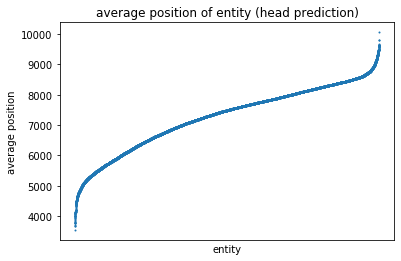

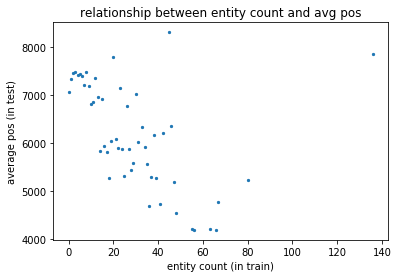

In [33]:
# analyse avg_position_table_head.pkl
path = os.path.join(model_output_path, 'avg_position_table_head.pkl')
avg_position_table_head = pd.read_pickle(path)

count_entities_highest = dict()  # train data
count_entities_highest_t = dict()  # test data
for entity_id in avg_position_table_head['entity_id'].head(10):
    try:
        entity_name = mid2name[id2entity[entity_id]]
    except:
        entity_name = entity_id
    count_entities_highest[entity_name] = count_head_entities_train[entity_id]
    count_entities_highest_t[entity_name] = count_head_entities_test[entity_id]

count_entities_lowest = dict()
count_entities_lowest_t = dict()
for entity_id in avg_position_table_head['entity_id'].tail(10):
    try:
        entity_name = mid2name[id2entity[entity_id]]
    except:
        entity_name = entity_id
    count_entities_lowest[entity_name] = count_head_entities_train[entity_id]
    count_entities_lowest_t[entity_name] = count_head_entities_test[entity_id]

print('\nstatistical values:')
display(avg_position_table_head.describe().round(1))
print('\n\nentities with lowest average position (top 10):')
entity_names = []
average_positions = []
for index, row in avg_position_table_head.head(10).iterrows():
    try:
        entity_name = mid2name[id2entity[row['entity_id']]]
    except:
        entity_name = row['entity_id']
    entity_names.append(entity_name)
    average_positions.append(row['average position'])
average_positions = [round(avg_pos) for avg_pos in average_positions]
avg_position_table_head_tmp = pd.DataFrame(columns=['entity_name', 'average position'])
avg_position_table_head_tmp['entity_name'] = entity_names
avg_position_table_head_tmp['average position'] = average_positions

avg_position_table_head_tmp['count head in train'] = avg_position_table_head_tmp['entity_name'].\
                                                     map(count_entities_highest)
avg_position_table_head_tmp['count head in test'] = avg_position_table_head_tmp['entity_name'].\
                                                    map(count_entities_highest_t)
display(avg_position_table_head_tmp.style.hide_index())
print('Hint: \"count head in train\" = number of occurrences of the entities in the training data (as head)')
print('\"count head in test\" = number of occurrences of the entities in the test data (as head)')

print('\n\nentities with highest average position (last 10):')
entity_names = []
average_positions = []
for index, row in avg_position_table_head.tail(10).iterrows():
    try:
        entity_name = mid2name[id2entity[row['entity_id']]]
    except:
        entity_name = row['entity_id']
    entity_names.append(entity_name)
    average_positions.append(row['average position'])
average_positions = [round(avg_pos) for avg_pos in average_positions]
avg_position_table_head_tmp = pd.DataFrame(columns=['entity_name', 'average position'])
avg_position_table_head_tmp['entity_name'] = entity_names
avg_position_table_head_tmp['average position'] = average_positions

avg_position_table_head_tmp['count head in train'] = avg_position_table_head_tmp['entity_name'].\
                                                     map(count_entities_lowest)
avg_position_table_head_tmp['count head in test'] = avg_position_table_head_tmp['entity_name'].\
                                                    map(count_entities_lowest_t)
display(avg_position_table_head_tmp.style.hide_index())
print()

y = avg_position_table_head['average position']
x = np.arange(len(y))
plt.figure()
plt.title('average position of entity (head prediction)')
plt.xlabel('entity')
plt.ylabel('average position')
plt.xticks([])
plt.scatter(x, y, s=1)
plt.show()

entity_count_to_avg_pos = dict()
for index, row in avg_position_table_head.iterrows():
    entity_count = count_head_entities_train[row['entity_id']]
    if entity_count not in entity_count_to_avg_pos:
        entity_count_to_avg_pos[entity_count] = (row['average position'], 1)
    else:
        entity_count_to_avg_pos[entity_count] = (entity_count_to_avg_pos[entity_count][0]
                                                 + row['average position'],
                                                 entity_count_to_avg_pos[entity_count][1] + 1)

for entity_count, (sum_avg_pos, num) in entity_count_to_avg_pos.items():
    entity_count_to_avg_pos[entity_count] = sum_avg_pos / num

x = []
y = []
for entity_count in sorted(entity_count_to_avg_pos):
    x.append(entity_count)
    y.append(entity_count_to_avg_pos[entity_count])    
    try:
        entity_name = mid2name[id2entity[entity_id]]
    except:
        entity_name = entity_id

plt.figure()
plt.title('relationship between entity count and avg pos')
plt.xlabel('entity count (in train)')
plt.ylabel('average pos (in test)')
plt.scatter(x, y, s=5)
plt.show()


statistical values:



,entity_id,average position
count,14541.0,14541.0
mean,7270.0,7270.0
std,4197.8,1679.1
min,0.0,2801.7
25%,3635.0,5884.0
50%,7270.0,7082.3
75%,10905.0,8832.2
max,14540.0,10926.9




entities with lowest average position (top 10):


entity_name,average position,count tail in train,count tail in test
Christianity,2802,8,2
Buddhism,2865,4,0
Islam,2887,5,0
Catholicism,2921,32,2
African Americans,2939,0,0
Protestantism,2965,7,0
marriage,2973,248,34
domestic partnership,2973,29,7
atheism,2987,24,0
Methodism,3034,5,0


Hint: "count tail in train" = number of occurrences of the entities in the training data (as tail)
"count tail in test" = number of occurrences of the entities in the test data (as tail)


entities with highest average position (last 10):


entity_name,average position,count tail in train,count tail in test
Steve Jobs,10510,0,0
Tim Allen,10515,2,0
Denis Leary,10516,1,1
Mako,10540,0,0
Kinji Fukasaku,10548,0,0
Brittany Murphy,10587,1,0
Stephanie Morgenstern,10671,2,0
Tim Curry,10694,0,1
Mel Blanc,10713,0,0
Clark Gregg,10927,1,0


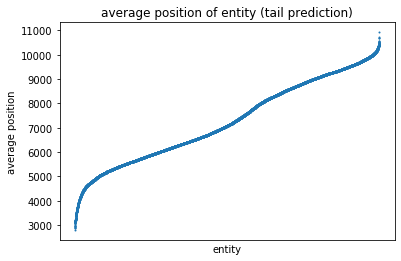

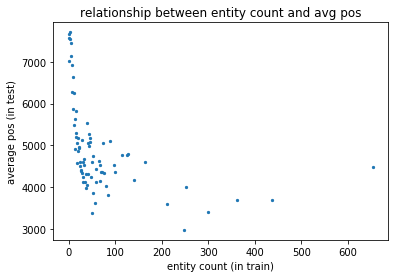

In [22]:
# analyse avg_position_table_tail.pkl
path = os.path.join(model_output_path, 'avg_position_table_tail.pkl')
avg_position_table_tail = pd.read_pickle(path)

count_entities_highest = dict()  # train data
count_entities_highest_t = dict()  # test data
for entity_id in avg_position_table_tail['entity_id'].head(10):
    try:
        entity_name = mid2name[id2entity[entity_id]]
    except:
        entity_name = entity_id
    count_entities_highest[entity_name] = count_tail_entities_train[entity_id]
    count_entities_highest_t[entity_name] = count_tail_entities_test[entity_id]

count_entities_lowest = dict()
count_entities_lowest_t = dict()
for entity_id in avg_position_table_tail['entity_id'].tail(10):
    try:
        entity_name = mid2name[id2entity[entity_id]]
    except:
        entity_name = entity_id
    count_entities_lowest[entity_name] = count_tail_entities_train[entity_id]
    count_entities_lowest_t[entity_name] = count_tail_entities_test[entity_id]

print('\nstatistical values:\n')
display(avg_position_table_tail.describe().round(1))

print('\n\nentities with lowest average position (top 10):')
entity_names = []
average_positions = []
for index, row in avg_position_table_tail.head(10).iterrows():
    try:
        entity_name = mid2name[id2entity[row['entity_id']]]
    except:
        entity_name = row['entity_id']
    entity_names.append(entity_name)
    average_positions.append(row['average position'])
average_positions = [round(avg_pos) for avg_pos in average_positions]
avg_position_table_tail_tmp = pd.DataFrame(columns=['entity_name', 'average position'])
avg_position_table_tail_tmp['entity_name'] = entity_names
avg_position_table_tail_tmp['average position'] = average_positions

avg_position_table_tail_tmp['count tail in train'] = avg_position_table_tail_tmp['entity_name'].\
                                                     map(count_entities_highest)
avg_position_table_tail_tmp['count tail in test'] = avg_position_table_tail_tmp['entity_name'].\
                                                    map(count_entities_highest_t)
display(avg_position_table_tail_tmp.style.hide_index())
print('Hint: \"count tail in train\" = number of occurrences of the entities in the training data (as tail)')
print('\"count tail in test\" = number of occurrences of the entities in the test data (as tail)')

print('\n\nentities with highest average position (last 10):')
entity_names = []
average_positions = []
for index, row in avg_position_table_tail.tail(10).iterrows():
    try:
        entity_name = mid2name[id2entity[row['entity_id']]]
    except:
        entity_name = row['entity_id']
    entity_names.append(entity_name)
    average_positions.append(row['average position'])
average_positions = [round(avg_pos) for avg_pos in average_positions]
avg_position_table_tail_tmp = pd.DataFrame(columns=['entity_name', 'average position'])
avg_position_table_tail_tmp['entity_name'] = entity_names
avg_position_table_tail_tmp['average position'] = average_positions

avg_position_table_tail_tmp['count tail in train'] = avg_position_table_tail_tmp['entity_name'].\
                                                     map(count_entities_lowest)
avg_position_table_tail_tmp['count tail in test'] = avg_position_table_tail_tmp['entity_name'].\
                                                    map(count_entities_lowest_t)
display(avg_position_table_tail_tmp.style.hide_index())
print()

y = avg_position_table_tail['average position']
x = np.arange(len(y))
plt.figure()
plt.title('average position of entity (tail prediction)')
plt.xlabel('entity')
plt.ylabel('average position')
plt.xticks([])
plt.scatter(x, y, s=1)
plt.show()

entity_count_to_avg_pos = dict()
for index, row in avg_position_table_tail.iterrows():
    entity_count = count_tail_entities_train[row['entity_id']]
    if entity_count not in entity_count_to_avg_pos:
        entity_count_to_avg_pos[entity_count] = (row['average position'], 1)
    else:
        entity_count_to_avg_pos[entity_count] = (entity_count_to_avg_pos[entity_count][0] +
                                                 row['average position'],
                                                 entity_count_to_avg_pos[entity_count][1] + 1)

for entity_count, (sum_avg_pos, num) in entity_count_to_avg_pos.items():
    entity_count_to_avg_pos[entity_count] = sum_avg_pos / num

x = []
y = []
for entity_count in sorted(entity_count_to_avg_pos):
    x.append(entity_count)
    y.append(entity_count_to_avg_pos[entity_count])

plt.figure()
plt.title('relationship between entity count and avg pos')
plt.xlabel('entity count (in train)')
plt.ylabel('average pos (in test)')
plt.scatter(x, y, s=5)
plt.show()

In [23]:
# analyse highly_ranked_table_head.pkl
path = os.path.join(model_output_path, 'highly_ranked_table_head.pkl')
highly_ranked_table_head = pd.read_pickle(path)

entity_in_top10_count_head = defaultdict(int)
for index, row in highly_ranked_table_head.iterrows():
    entity_in_top10_count_head[row['entity_id']] = row['count']

count_entities_highest = dict()
for entity_id in highly_ranked_table_head['entity_id'].head(10):
    try:
        entity_name = mid2name[id2entity[entity_id]]
    except:
        entity_name = entity_id
    count_entities_highest[entity_name] = count_head_entities_train[entity_id]

count_entities_lowest = dict()
for entity_id in highly_ranked_table_head['entity_id'].tail(10):
    try:
        entity_name = mid2name[id2entity[entity_id]]
    except:
        entity_name = entity_id
    count_entities_lowest[entity_name] = count_head_entities_train[entity_id]

print('\nstatistical values:\n')
display(highly_ranked_table_head.describe().round(1))

print('\n\nentities with highest count (top 10)')
print('(shows how often the respective entity gets a position between 1 and 10)\n')
entity_names = []
counts = []
for index, row in highly_ranked_table_head.head(10).iterrows():
    try:
        entity_name = mid2name[id2entity[row['entity_id']]]
    except:
        entity_name = row['entity_id']
    entity_names.append(entity_name)
    counts.append(row['count'])
highly_ranked_table_head_tmp = pd.DataFrame(columns=['entity_name', 'count'])
highly_ranked_table_head_tmp['entity_name'] = entity_names
highly_ranked_table_head_tmp['count'] = counts

highly_ranked_table_head_tmp['count head in train'] = highly_ranked_table_head_tmp['entity_name'].\
                                                      map(count_entities_highest)
display(highly_ranked_table_head_tmp.style.hide_index())

print('\n\nentities with lowest count (last 10)')
print('(shows how often the respective entity gets a position between 1 and 10)\n')
entity_names = []
counts = []
for index, row in highly_ranked_table_head.tail(10).iterrows():
    try:
        entity_name = mid2name[id2entity[row['entity_id']]]
    except:
        entity_name = row['entity_id']
    entity_names.append(entity_name)
    counts.append(row['count'])
highly_ranked_table_head_tmp = pd.DataFrame(columns=['entity_name', 'count'])
highly_ranked_table_head_tmp['entity_name'] = entity_names
highly_ranked_table_head_tmp['count'] = counts

highly_ranked_table_head_tmp['count head in train'] = highly_ranked_table_head_tmp['entity_name'].\
                                                      map(count_entities_lowest)
display(highly_ranked_table_head_tmp.style.hide_index())

mask = highly_ranked_table_head['count'] > 100
num = highly_ranked_table_head[mask].shape[0]
print('\nnumber of entities with count > 100: ' + str(num))

mask = highly_ranked_table_head['count'] == 0
num = highly_ranked_table_head[mask].shape[0]
print('number of entities with count 0: ' + str(num))

mask = highly_ranked_table_head['count'] == 1
num = highly_ranked_table_head[mask].shape[0]
print('number of entities with count 1: ' + str(num))

mask = highly_ranked_table_head['count'] < 10
num = highly_ranked_table_head[mask].shape[0]
print('number of entities with count < 10: ' + str(num))


statistical values:



,entity_id,count
count,7338.0,7338.0
mean,7352.1,27.9
std,4233.2,63.5
min,1.0,1.0
25%,3674.2,2.0
50%,7384.5,6.0
75%,11085.8,26.0
max,14540.0,1663.0




entities with highest count (top 10)
(shows how often the respective entity gets a position between 1 and 10)



entity_name,count,count head in train
Carrie Fisher,1663,0
Al Gore,1238,7
David Hasselhoff,1117,2
Dolph Lundgren,1038,3
Isabella Rossellini,694,1
David Carradine,646,2
Jay Leno,612,4
Albert Brooks,612,4
John Cleese,579,4
Steve Jobs,572,1




entities with lowest count (last 10)
(shows how often the respective entity gets a position between 1 and 10)



entity_name,count,count head in train
Ogden,1,0
Charlie Cox,1,7
Gretchen Mol,1,3
Primetime Emmy Award for Outstanding Short Form Animated Program,1,0
Hannah Montana: The Movie,1,7
Williamsport,1,0
Lycoming County,1,0
Decatur,1,1
Walnut Creek,1,0
Terry Gilliam,1,3



number of entities with count > 100: 496
number of entities with count 0: 0
number of entities with count 1: 1630
number of entities with count < 10: 4229


In [24]:
# analyse highly_ranked_table_tail.pkl
path = os.path.join(model_output_path, 'highly_ranked_table_tail.pkl')
highly_ranked_table_tail = pd.read_pickle(path)

entity_in_top10_count_tail = defaultdict(int)
for index, row in highly_ranked_table_tail.iterrows():
    entity_in_top10_count_tail[row['entity_id']] = row['count']

count_entities_highest = dict()
for entity_id in highly_ranked_table_tail['entity_id'].head(10):
    try:
        entity_name = mid2name[id2entity[entity_id]]
    except:
        entity_name = entity_id
    count_entities_highest[entity_name] = count_tail_entities_train[entity_id]
    
count_entities_lowest = dict()
for entity_id in highly_ranked_table_tail['entity_id'].tail(10):
    try:
        entity_name = mid2name[id2entity[entity_id]]
    except:
        entity_name = entity_id
    count_entities_lowest[entity_name] = count_tail_entities_train[entity_id]

print('\nstatistical values:\n')
display(highly_ranked_table_tail.describe().round(1))

print('\n\nentities with highest count (top 10)')
print('(shows how often the respective entity gets a position between 1 and 10)')
entity_names = []
counts = []
for index, row in highly_ranked_table_tail.head(10).iterrows():
    try:
        entity_name = mid2name[id2entity[row['entity_id']]]
    except:
        entity_name = row['entity_id']
    entity_names.append(entity_name)
    counts.append(row['count'])
highly_ranked_table_tail_tmp = pd.DataFrame(columns=['entity_name', 'count'])
highly_ranked_table_tail_tmp['entity_name'] = entity_names
highly_ranked_table_tail_tmp['count'] = counts

highly_ranked_table_tail_tmp['count tail in train'] = highly_ranked_table_tail_tmp['entity_name'].\
                                                      map(count_entities_highest)
display(highly_ranked_table_tail_tmp.style.hide_index())

print('\n\nentities with lowest count (last 10)')
print('(shows how often the respective entity gets a position between 1 and 10)')
entity_names = []
counts = []
for index, row in highly_ranked_table_tail.tail(10).iterrows():
    try:
        entity_name = mid2name[id2entity[row['entity_id']]]
    except:
        entity_name = row['entity_id']
    entity_names.append(entity_name)
    counts.append(row['count'])
highly_ranked_table_tail_tmp = pd.DataFrame(columns=['entity_name', 'count'])
highly_ranked_table_tail_tmp['entity_name'] = entity_names
highly_ranked_table_tail_tmp['count'] = counts

highly_ranked_table_tail_tmp['count tail in train'] = highly_ranked_table_tail_tmp['entity_name'].\
                                                      map(count_entities_lowest)
display(highly_ranked_table_tail_tmp.style.hide_index())

mask = highly_ranked_table_tail['count'] > 100
num = highly_ranked_table_tail[mask].shape[0]
print('\nnumber of entities with count > 100: ' + str(num))

mask = highly_ranked_table_tail['count'] == 0
num = highly_ranked_table_tail[mask].shape[0]
print('number of entities with count 0: ' + str(num))

mask = highly_ranked_table_tail['count'] == 1
num = highly_ranked_table_tail[mask].shape[0]
print('number of entities with count 1: ' + str(num))

mask = highly_ranked_table_tail['count'] < 10
num = highly_ranked_table_tail[mask].shape[0]
# print('number of entities with count < 10: ' + str(num))


statistical values:



,entity_id,count
count,7570.0,7570.0
mean,7298.7,27.0
std,4217.2,70.4
min,1.0,1.0
25%,3630.5,2.0
50%,7344.5,6.0
75%,10972.8,20.0
max,14538.0,983.0




entities with highest count (top 10)
(shows how often the respective entity gets a position between 1 and 10)


entity_name,count,count tail in train
businessperson,983,7
television producer,972,53
screenwriter,886,84
television director,859,31
Slovakia,805,13
New Zealand,803,27
male organism,788,300
female organism,786,81
domestic partnership,761,29
marriage,756,248




entities with lowest count (last 10)
(shows how often the respective entity gets a position between 1 and 10)


entity_name,count,count tail in train
Guinea,1,1
Silver Spring,1,0
Ogden,1,1
Justin Timberlake,1,9
brain tumor,1,0
Neil Jordan,1,2
Robert Bolt,1,2
Jack Benny,1,1
William Goldman,1,3
Decatur,1,0



number of entities with count > 100: 451
number of entities with count 0: 0
number of entities with count 1: 1668


In [29]:
# analyse top_ranked_table_head.pkl
path = os.path.join(model_output_path, 'top_ranked_table_head.pkl')
top_ranked_table_head = pd.read_pickle(path)

entity_first_place_count_head = defaultdict(int)
for index, row in top_ranked_table_head.iterrows():
    entity_first_place_count_head[row['entity_id']] = row['count']

count_entities_highest = dict()
for entity_id in top_ranked_table_head['entity_id'].head(10):
    try:
        entity_name = mid2name[id2entity[entity_id]]
    except:
        entity_name = entity_id
    count_entities_highest[entity_name] = count_head_entities_train[entity_id]

count_entities_lowest = dict()
for entity_id in top_ranked_table_head['entity_id'].tail(10):
    try:
        entity_name = mid2name[id2entity[entity_id]]
    except:
        entity_name = entity_id
    count_entities_lowest[entity_name] = count_head_entities_train[entity_id]

print('\nstatistical values:\n')
display(top_ranked_table_head.describe().round(1))

print('\n\nentities with highest count (top 10)')
print('(shows how often the respective entity is on the first place in models ranking)\n')
entity_names = []
counts = []
for index, row in top_ranked_table_head.head(10).iterrows():
    try:
        entity_name = mid2name[id2entity[row['entity_id']]]
    except:
        entity_name = row['entity_id']
    entity_names.append(entity_name)
    counts.append(row['count'])
top_ranked_table_head_tmp = pd.DataFrame(columns=['entity_name', 'count'])
top_ranked_table_head_tmp['entity_name'] = entity_names
top_ranked_table_head_tmp['count'] = counts

top_ranked_table_head_tmp['count head in train'] = top_ranked_table_head_tmp['entity_name'].\
                                                   map(count_entities_highest)
display(top_ranked_table_head_tmp.style.hide_index())

print('\n\nentities with lowest count (last 10)')
print('(shows how often the respective entity is on the first place in models ranking)\n')
entity_names = []
counts = []
for index, row in top_ranked_table_head.tail(10).iterrows():
    try:
        entity_name = mid2name[id2entity[row['entity_id']]]
    except:
        entity_name = row['entity_id']
    entity_names.append(entity_name)
    counts.append(row['count'])
top_ranked_table_head_tmp = pd.DataFrame(columns=['entity_name', 'count'])
top_ranked_table_head_tmp['entity_name'] = entity_names
top_ranked_table_head_tmp['count'] = counts

top_ranked_table_head_tmp['count head in train'] = top_ranked_table_head_tmp['entity_name'].\
                                                   map(count_entities_lowest)
display(top_ranked_table_head_tmp.style.hide_index())

mask = top_ranked_table_head['count'] > 100
num = top_ranked_table_head[mask].shape[0]
print('\nnumber of entities with count > 100: ' + str(num))

mask = top_ranked_table_head['count'] == 0
num = top_ranked_table_head[mask].shape[0]
print('number of entities with count 0: ' + str(num))

mask = top_ranked_table_head['count'] == 1
num = top_ranked_table_head[mask].shape[0]
print('number of entities with count 1: ' + str(num))

mask = top_ranked_table_head['count'] < 10
num = top_ranked_table_head[mask].shape[0]
print('number of entities with count < 10: ' + str(num))


statistical values:



,entity_id,count
count,750.0,750.0
mean,7166.4,2.7
std,4181.8,6.5
min,34.0,1.0
25%,3659.5,1.0
50%,7357.0,1.0
75%,10814.5,2.0
max,14491.0,82.0




entities with highest count (top 10)
(shows how often the respective entity is on the first place in models ranking)



entity_name,count,count head in train
Jamie Lee Curtis,82,1
Tyler Perry,76,0
Abraham Lincoln: Vampire Hunter,71,11
Dolph Lundgren,62,3
Around the World in 80 Days,59,5
Lara Croft Tomb Raider: The Cradle of Life,53,4
Flo Rida,34,0
Broadcast Film Critics Association Award for Best Film,28,10
David Carradine,17,2
University of Michigan,16,5




entities with lowest count (last 10)
(shows how often the respective entity is on the first place in models ranking)



entity_name,count,count head in train
Evan Almighty,1,1
Toy Story 3,1,8
adult contemporary music,1,1
23rd Academy Awards,1,1
Kingdom of Bulgaria,1,1
Austria,1,9
Grammy Award for Best Country Collaboration with Vocals,1,2
World Fantasy Award for Best Short Fiction,1,1
Michigan,1,6
banjo,1,19



number of entities with count > 100: 0
number of entities with count 0: 0
number of entities with count 1: 464
number of entities with count < 10: 722


In [35]:
# analyse top_ranked_table_tail.pkl
path = os.path.join(model_output_path, 'top_ranked_table_tail.pkl')
top_ranked_table_tail = pd.read_pickle(path)

entity_first_place_count_tail = defaultdict(int)
for index, row in top_ranked_table_tail.iterrows():
    entity_first_place_count_tail[row['entity_id']] = row['count']

count_entities_highest = dict()
for entity_id in top_ranked_table_tail['entity_id'].head(10):
    try:
        entity_name = mid2name[id2entity[entity_id]]
    except:
        entity_name = entity_id
    count_entities_highest[entity_name] = count_tail_entities_train[entity_id]

count_entities_lowest = dict()
for entity_id in top_ranked_table_tail['entity_id'].tail(10):
    try:
        entity_name = mid2name[id2entity[entity_id]]
    except:
        entity_name = entity_id
    count_entities_lowest[entity_name] = count_tail_entities_train[entity_id]

print('\nstatistical values:\n')
display(top_ranked_table_tail.describe().round(1))

print('\n\nentities with highest count (top 10)')
print('(shows how often the respective entity is on the first place in models ranking)')
entity_names = []
counts = []
for index, row in top_ranked_table_tail.head(10).iterrows():
    try:
        entity_name = mid2name[id2entity[row['entity_id']]]
    except:
        entity_name = row['entity_id']
    entity_names.append(entity_name)
    counts.append(row['count'])
top_ranked_table_tail_tmp = pd.DataFrame(columns=['entity_name', 'count'])
top_ranked_table_tail_tmp['entity_name'] = entity_names
top_ranked_table_tail_tmp['count'] = counts

top_ranked_table_tail_tmp['count tail in train'] = top_ranked_table_tail_tmp['entity_name'].\
                                                   map(count_entities_highest)
display(top_ranked_table_tail_tmp.style.hide_index())

print('\n\nentities with lowest count (last 10)')
print('(shows how often the respective entity is on the first place in models ranking)')
entity_names = []
counts = []
for index, row in top_ranked_table_tail.tail(10).iterrows():
    try:
        entity_name = mid2name[id2entity[row['entity_id']]]
    except:
        entity_name = row['entity_id']
    entity_names.append(entity_name)
    counts.append(row['count'])
top_ranked_table_tail_tmp = pd.DataFrame(columns=['entity_name', 'count'])
top_ranked_table_tail_tmp['entity_name'] = entity_names
top_ranked_table_tail_tmp['count'] = counts

top_ranked_table_tail_tmp['count tail in train'] = top_ranked_table_tail_tmp['entity_name'].\
                                                   map(count_entities_lowest)
display(top_ranked_table_tail_tmp.style.hide_index())

mask = top_ranked_table_tail['count'] > 100
num = top_ranked_table_tail[mask].shape[0]
print('\nnumber of entities with count > 100: ' + str(num))

mask = top_ranked_table_tail['count'] == 0
num = top_ranked_table_tail[mask].shape[0]
print('number of entities with count 0: ' + str(num))

mask = top_ranked_table_tail['count'] == 1
num = top_ranked_table_tail[mask].shape[0]
print('number of entities with count 1: ' + str(num))

mask = top_ranked_table_tail['count'] < 10
num = top_ranked_table_tail[mask].shape[0]
print('number of entities with count < 10: ' + str(num))



statistical values:



,entity_id,count
count,771.0,771.0
mean,7325.5,2.7
std,3939.2,4.4
min,44.0,1.0
25%,4262.5,1.0
50%,7345.0,1.0
75%,10726.0,2.0
max,14522.0,56.0




entities with highest count (top 10)
(shows how often the respective entity is on the first place in models ranking)


entity_name,count,count tail in train
Hungary,56,22
Denmark,45,33
10191,34,361
United States of America,34,654
male organism,29,300
United States dollar,23,438
Arnold Schwarzenegger,22,4
special effects supervisor,22,58
domestic partnership,21,29
English,21,252




entities with lowest count (last 10)
(shows how often the respective entity is on the first place in models ranking)


entity_name,count,count tail in train
Grammy Award for Best Tropical Latin Album,1,0
Beastie Boys,1,4
Hull City A.F.C.,1,2
Bonnie Hunt,1,1
Primetime Emmy Award for Outstanding Guest Actor in a Drama Series,1,8
Charles Dickens,1,4
Ridley Scott,1,6
fantasy,1,34
Germany,1,60
German Empire,1,5



number of entities with count > 100: 0
number of entities with count 0: 0
number of entities with count 1: 472
number of entities with count < 10: 738


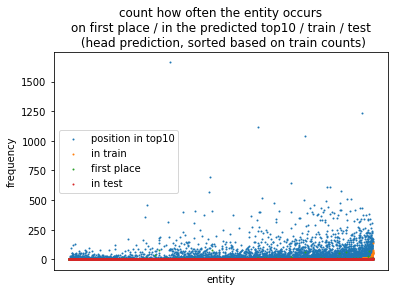

most intersting section:


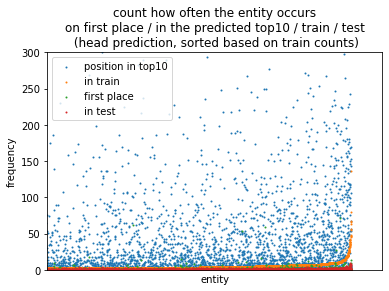


entities that were predicted far too often:


entity,true head count,pred head count,difference,head in train count,entity in train count
Jamie Lee Curtis,0,82,82,1,4
Tyler Perry,0,76,76,0,0
Abraham Lincoln: Vampire Hunter,0,71,71,11,11
Dolph Lundgren,1,62,61,3,3
Around the World in 80 Days,0,59,59,5,8
Lara Croft Tomb Raider: The Cradle of L...,0,53,53,4,5
Flo Rida,1,34,33,0,2
Broadcast Film Critics Association Awar...,1,28,27,10,12
David Carradine,0,17,17,2,2
David Lee Roth,0,15,15,3,4




entities that were predicted far too seldom:


entity,true head count,pred head count,difference,head in train count,entity in train count
Bachelor of Arts,10,0,-10,41,41
rock music,6,0,-6,36,40
drum kit,6,1,-5,35,49
master's degree,5,0,-5,16,16
BAFTA Award for Best Film,4,0,-4,15,32
Big Fish,4,0,-4,6,6
guitar,5,1,-4,80,126
Academy Award for Best Supporting Actor,4,0,-4,29,47
indie rock,4,0,-4,6,11
Germany,4,0,-4,17,77


In [31]:
# head prediction: plot how often the entity occurs in the predicted top10 / on first place / train / 
# test (sorted based on train counts)
y_train = []
y_test = []
y_predicted_top10 = []
y_predicted_top1 = []

all_entities = list(id2entity.keys())
all_head_entities_train = list(count_head_entities_train.keys())
entities_not_head_in_train = np.setdiff1d(all_entities, all_head_entities_train)
assert len(all_entities) == len(entities_not_head_in_train) + len(all_head_entities_train)

for entity_id in entities_not_head_in_train:
    y_train.append(count_head_entities_train[entity_id])
    y_test.append(count_head_entities_test[entity_id])
    y_predicted_top10.append(entity_in_top10_count_head[entity_id])
    y_predicted_top1.append(entity_first_place_count_head[entity_id])

for entity_id in sorted(count_head_entities_train, key=count_head_entities_train.get):
    y_train.append(count_head_entities_train[entity_id])
    y_test.append(count_head_entities_test[entity_id])
    y_predicted_top10.append(entity_in_top10_count_head[entity_id])
    y_predicted_top1.append(entity_first_place_count_head[entity_id])
    
assert len(y_train) == len(y_test)
assert len(y_test) == len(y_predicted_top10)
assert len(y_test) == len(y_predicted_top1)
x = [i for i in range(len(y_train))]

plt.figure()
plt.title('count how often the entity occurs\non first place / in the predicted top10 / train / ' \
          + 'test\n (head prediction, sorted based on train counts)')
plt.xlabel('entity')
plt.ylabel('frequency')
plt.xticks([])

plt.scatter(x, y_predicted_top10, label='position in top10', s=1)
plt.scatter(x, y_train, label='in train', s=1)
plt.scatter(x, y_predicted_top1, label='first place', s=1)
plt.scatter(x, y_test, label='in test', s=1)
plt.legend()
plt.show()

print('most intersting section:')

plt.figure()
plt.title('count how often the entity occurs\non first place / in the predicted top10 / train / ' \
          + 'test\n (head prediction, sorted based on train counts)')
plt.xlabel('entity')
plt.ylabel('frequency')
plt.xticks([])

plt.scatter(x, y_predicted_top10, label='position in top10', s=1)
plt.scatter(x, y_train, label='in train', s=1)
plt.scatter(x, y_predicted_top1, label='first place', s=1)
plt.scatter(x, y_test, label='in test', s=1)
plt.legend()
plt.axis([10000, 15000, 0, 300])  # xmin, xmax, ymin, ymax
plt.show()

entity_ids = []
differences = []  # difference between count predicted and count true
true_head_counts = []
pred_head_counts = []
head_in_train_counts = []
entity_in_train_counts = []

for entity_id in id2entity.keys():
    entity_ids.append(entity_id)
    true_head_counts.append(count_head_entities_test[entity_id])
    pred_head_counts.append(entity_first_place_count_head[entity_id])
    difference = entity_first_place_count_head[entity_id] - count_head_entities_test[entity_id]
    differences.append(difference)
    head_in_train_counts.append(count_head_entities_train[entity_id])
    entity_in_train_counts.append(count_head_entities_train[entity_id]
                                  + count_tail_entities_train[entity_id])

entity_names = []
for entity_id in entity_ids:
    try:
        entity_name = mid2name[id2entity[entity_id]]
        if len(entity_name) > 39:
            entity_name = entity_name[:39] + '...'
        entity_names.append(entity_name)
    except:
        entity_names.append(entity_id)

difference_df = pd.DataFrame(columns=['entity', 'true head count', 'pred head count', 'difference', 
                                      'head in train count', 'entity in train count'])
difference_df['entity'] = entity_names
difference_df['true head count'] = true_head_counts
difference_df['pred head count'] = pred_head_counts
difference_df['difference'] = differences
difference_df['head in train count'] = head_in_train_counts
difference_df['entity in train count'] = entity_in_train_counts
difference_df = difference_df.sort_values(by='difference', ascending=False)

print('\nentities that were predicted far too often:')
display(difference_df.head(10).style.hide_index())
print('\n\nentities that were predicted far too seldom:')
display(difference_df.tail(10).sort_values(by='difference').style.hide_index())

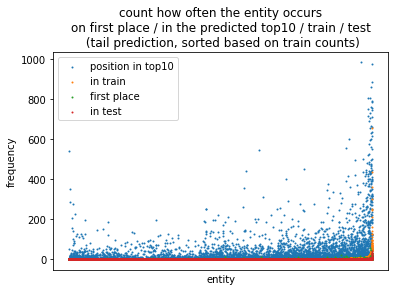

most intersting section:


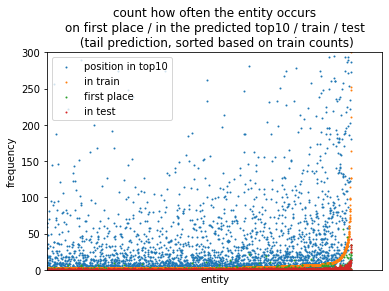


entities that were predicted far too often:


entity,true tail count,pred tail count,difference,tail in train count,entity in train count
Hungary,4,56,52,22,25
Denmark,2,45,43,33,37
Arnold Schwarzenegger,0,22,22,4,7
Carrie Fisher,0,19,19,4,4
Spanish,2,18,16,23,26
Rod Stewart,0,14,14,5,9
10735,1,15,14,6,8
romance film,4,18,14,37,39
domestic partnership,7,21,14,29,31
Iraq,0,13,13,3,9




entities that were predicted far too seldom:


entity,true tail count,pred tail count,difference,tail in train count,entity in train count
marriage,34,20,-14,248,289
English,32,21,-11,252,258
Argentina,10,0,-10,45,48
production sound mixer,11,1,-10,76,76
actor,24,15,-9,211,211
Australia,9,0,-9,51,62
Germany,9,1,-8,60,77
United States of America,42,34,-8,654,790
art director,7,0,-7,16,16
record producer,6,0,-6,35,35


In [32]:
# tail prediction: plot how often the entity occurs in the predicted top10 / on first place / train /
# test (sorted based on train counts)
y_train = []
y_test = []
y_predicted_top10 = []
y_predicted_top1 = []

all_tail_entities_train = list(count_tail_entities_train.keys())
entities_not_tail_in_train = np.setdiff1d(all_entities, all_tail_entities_train)
assert len(all_entities) == len(entities_not_tail_in_train) + len(all_tail_entities_train)

for entity_id in entities_not_tail_in_train:
    y_train.append(count_tail_entities_train[entity_id])
    y_test.append(count_tail_entities_test[entity_id])
    y_predicted_top10.append(entity_in_top10_count_tail[entity_id])
    y_predicted_top1.append(entity_first_place_count_tail[entity_id])

for entity_id in sorted(count_tail_entities_train, key=count_tail_entities_train.get):
    y_train.append(count_tail_entities_train[entity_id])
    y_test.append(count_tail_entities_test[entity_id])
    y_predicted_top10.append(entity_in_top10_count_tail[entity_id])
    y_predicted_top1.append(entity_first_place_count_tail[entity_id])
    
assert len(y_train) == len(y_test)
assert len(y_test) == len(y_predicted_top10)
assert len(y_test) == len(y_predicted_top1)
x = [i for i in range(len(y_train))]

plt.figure()
plt.title('count how often the entity occurs\non first place / in the predicted top10 / train / ' \
          + 'test\n (tail prediction, sorted based on train counts)')
plt.xlabel('entity')
plt.ylabel('frequency')
plt.xticks([])

plt.scatter(x, y_predicted_top10, label='position in top10', s=1)
plt.scatter(x, y_train, label='in train', s=1)
plt.scatter(x, y_predicted_top1, label='first place', s=1)
plt.scatter(x, y_test, label='in test', s=1)
plt.legend()
plt.show()

print('most intersting section:')

plt.figure()
plt.title('count how often the entity occurs\non first place / in the predicted top10 / train / ' \
          + 'test\n (tail prediction, sorted based on train counts)')
plt.xlabel('entity')
plt.ylabel('frequency')
plt.xticks([])

plt.scatter(x, y_predicted_top10, label='position in top10', s=1)
plt.scatter(x, y_train, label='in train', s=1)
plt.scatter(x, y_predicted_top1, label='first place', s=1)
plt.scatter(x, y_test, label='in test', s=1)
plt.legend()
plt.axis([10000, 15000, 0, 300])  # xmin, xmax, ymin, ymax
plt.show()

entity_ids = []
differences = []  # difference between count predicted and count true
true_tail_counts = []
pred_tail_counts = []
tail_in_train_counts = []
entity_in_train_counts = []

for entity_id in id2entity.keys():
    entity_ids.append(entity_id)
    true_tail_counts.append(count_tail_entities_test[entity_id])
    pred_tail_counts.append(entity_first_place_count_tail[entity_id])
    difference = entity_first_place_count_tail[entity_id] - count_tail_entities_test[entity_id]
    differences.append(difference)
    tail_in_train_counts.append(count_tail_entities_train[entity_id])
    entity_in_train_counts.append(count_head_entities_train[entity_id]
                                  + count_tail_entities_train[entity_id])

entity_names = []
for entity_id in entity_ids:
    try:
        entity_name = mid2name[id2entity[entity_id]]
        if len(entity_name) > 39:
            entity_name = entity_name[:39] + '...'
        entity_names.append(entity_name)
    except:
        entity_names.append(entity_id)

difference_df = pd.DataFrame(columns=['entity', 'true tail count', 'pred tail count', 'difference', 
                                      'tail in train count', 'entity in train count'])
difference_df['entity'] = entity_names
difference_df['true tail count'] = true_tail_counts
difference_df['pred tail count'] = pred_tail_counts
difference_df['difference'] = differences
difference_df['tail in train count'] = tail_in_train_counts
difference_df['entity in train count'] = entity_in_train_counts
difference_df = difference_df.sort_values(by='difference', ascending=False)

print('\nentities that were predicted far too often:')
display(difference_df.head(10).style.hide_index())
print('\n\nentities that were predicted far too seldom:')
display(difference_df.tail(10).sort_values(by='difference').style.hide_index())